In [1]:
import sys
import os
import cv2
import random
import itertools
import shutil
import glob
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
import seaborn as sn
import regex as re
from skimage  import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage as nd
from PIL import Image
import plotly
import tensorflow.keras
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model ,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Input,add,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate 
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import plot_confusion_matrix, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
%matplotlib inline

Using TensorFlow backend.


# splitting some testing letters with upper dots From the rest of the letters

In [4]:
KaggleTest_x = pd.read_csv("KaggletestingImagesCleaned.csv",header=None )
KaggleTest_y = pd.read_csv("KaggletestingLabelsCleaned.csv" ,header=None)


KaggleTest_y.columns.values[0] = 1111

KaggleTest_x = pd.concat([KaggleTest_x, KaggleTest_y], axis=1)

GetseperateLettersTest= ((KaggleTest_x[1111] == 7) | (KaggleTest_x[1111] == 9) | (KaggleTest_x[1111] == 11 )
               | (KaggleTest_x[1111] == 15) | (KaggleTest_x[1111] == 19) ) 

# Letters you want to augment separately like (zaay, Khaa)
seperateLettersTest = KaggleTest_x[GetseperateLettersTest]
seperateLettersTest.reset_index(drop=True, inplace=True)

seperateLettersTest_labels = pd.DataFrame(seperateLettersTest[1111])
seperateLettersTest_labels.columns.values[0] = 0

# You will get two dataframes seperateLettersTest and seperateLettersTest_labels
seperateLettersTest
seperateLettersTest_labels


# Letters you want to augment normally
df_new = KaggleTest_x.drop(KaggleTest_x[GetseperateLettersTest].index)
df_new.reset_index(drop=True, inplace=True)

df_new_labels = pd.DataFrame(df_new[1111])
df_new_labels.columns.values[0] = 0

df_new.drop([1111], axis=1, inplace=True)

# You will get two dataframes KaggleTest_x and KaggleTest_x_labels
KaggleTest_x = df_new.copy()
KaggleTest_y = df_new_labels.copy()

seperateLettersTest.drop([1111], axis=1, inplace=True)

In [5]:
KaggleTest_x.shape, seperateLettersTest.shape,KaggleTest_y.shape,seperateLettersTest_labels.shape

((2754, 1024), (600, 1024), (2754, 1), (600, 1))

# splitting some training letters with upper dots From the rest of the letters

In [30]:
KaggleTrain_x = pd.read_csv("KaggletrainingImagesCleaned.csv",header=None )
KaggleTrain_y = pd.read_csv("KaggletrainingLabelsCleaned.csv" ,header=None)


KaggleTrain_y.columns.values[0] = 1111

KaggleTrain_x = pd.concat([KaggleTrain_x, KaggleTrain_y], axis=1)

GetseperateLettersTrain= ((KaggleTrain_x[1111] == 7) | (KaggleTrain_x[1111] == 9) | (KaggleTrain_x[1111] == 11 )
               | (KaggleTrain_x[1111] == 15) | (KaggleTrain_x[1111] == 19) ) 

# Letters you want to augment separately like (zaay, khaa)
seperateLettersTrain = KaggleTrain_x[GetseperateLettersTrain]
seperateLettersTrain.reset_index(drop=True, inplace=True)

seperateLettersTrain_labels = pd.DataFrame(seperateLettersTrain[1111])
seperateLettersTrain_labels.columns.values[0] = 0

# You will get two dataframes seperateLettersTrain and seperateLettersTrain_labels
seperateLettersTrain
seperateLettersTrain_labels


# Letters you want to augment normally
df_new_train = KaggleTrain_x.drop(KaggleTrain_x[GetseperateLettersTrain].index)
df_new_train.reset_index(drop=True, inplace=True)

df_new_labels_train = pd.DataFrame(df_new_train[1111])
df_new_labels_train.columns.values[0] = 0

df_new_train.drop([1111], axis=1, inplace=True)

# You will get two dataframes KaggleTest_x and seperateLettersTrain_labels
KaggleTrain_x = df_new_train.copy()
KaggleTrain_y = df_new_labels_train.copy()


seperateLettersTrain.drop([1111], axis=1, inplace=True)

In [31]:
KaggleTrain_x.shape, seperateLettersTrain.shape

((10983, 1024), (2393, 1024))

In [32]:
KaggleTrain_x,KaggleTrain_x_vaildation,KaggleTrain_y,KaggleTrain_y_vaildation=train_test_split(KaggleTrain_x, KaggleTrain_y, test_size = 0.1,random_state = 10, stratify = KaggleTrain_y)
KaggleTrain_x,KaggleTrain_y

(       0     1     2     3     4     5     6     7     8     9     ...  1014  \
 1378      0     0     0     0     0     0     0     0     0     0  ...     0   
 4376      0     0     0     0     0     0     0     0     0     0  ...     0   
 1579      0     0     0     0     0     0     0     0     0     0  ...     0   
 3466      0     0     0     0     0     0     0     0     0     0  ...     0   
 9088      0     0     0     0     0     0     0     0     0     0  ...     0   
 ...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 10454     0     0     0     0     0     0     0     0     0     0  ...     0   
 7364      0     0     0     0     0     0     0     0     0     0  ...     0   
 4289      0    31    50     1     0     0     0     0     0     0  ...     0   
 9097      0     0     0     0     0     0     0     0     0     0  ...     0   
 4552      0     0     0     0     0     0     0     0     0     0  ...     0   
 
        1015  1016  1017  

In [13]:
seperateLettersTrain,seperateLettersTrain_vaildation,seperateLettersTrain_labels,seperateLettersTrain_labels_vaildation=train_test_split(seperateLettersTrain, seperateLettersTrain_labels, test_size = 0.1,random_state = 10, stratify = seperateLettersTrain_labels)
seperateLettersTrain,seperateLettersTrain_labels

(      0     1     2     3     4     5     6     7     8     9     ...  1014  \
 908      0     0     0     0     0     0     0     0     0     0  ...     0   
 726      0     0     0     0     0     0     0     0     0     0  ...     0   
 1648     0     0     0     0     0     0     0     0     0     0  ...     0   
 195      0     0     0     0     0     0     0     0     0     0  ...     0   
 985      0     0     0     0     0     0     0     0     0     0  ...     0   
 ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 537      0     0     0     0     0     0     0     0     0     0  ...     0   
 1249     0     0     0     0     0     0     0     0     0     0  ...     0   
 2335     0     0     0     0     0     0     0     0     0     0  ...     0   
 88       0     0     0     0     0     0     0     0     0     0  ...     0   
 653      0     0     0     0     0     0     0     0     0     0  ...     0   
 
       1015  1016  1017  1018  1019  1

In [33]:
frames_x=[KaggleTrain_x,seperateLettersTrain]
df_x=pd.concat(frames_x)
frames_y=[KaggleTrain_y,seperateLettersTrain_labels]
df_y=pd.concat(frames_y)



frames_x_vaildation=[KaggleTrain_x_vaildation,seperateLettersTrain_vaildation]
df_x_vaildation=pd.concat(frames_x_vaildation)
frames_y_vaildation=[KaggleTrain_y_vaildation,seperateLettersTrain_labels_vaildation]
df_y_vaildation=pd.concat(frames_y_vaildation)

print(df_y.shape,df_y_vaildation.shape)
df_x.to_csv("KaggletrainingImagesCleaned.csv",index=False , header=False)
df_y.to_csv("KaggletrainingLabelsCleaned.csv",index=False , header=False)

df_x_vaildation.to_csv("KagglevaildationImagesCleaned.csv",index=False , header=False)
df_y_vaildation.to_csv("KagglevaildationLabelsCleaned.csv",index=False , header=False)

(12277, 1) (1339, 1)


# Data Augmentaion for Testing Images

In [15]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = KaggleTest_x
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=2754,  
                          save_to_dir='augmented TestImages 23 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLettersTest
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=600,  
                          save_to_dir='augmented TestImages 5 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Data Augmentaion for Training Images

In [16]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = KaggleTrain_x
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=9884,  
                          save_to_dir='augmented TrainImages 23 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLettersTrain
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=2153,  
                          save_to_dir='augmented TrainImages 5 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Data Augmentaion for Vaildation

In [14]:
KaggleTrain_x_vaildation.shape,seperateLettersTrain_vaildation.shape

((1099, 1024), (240, 1024))

In [17]:
# Augmentaion for the 23 letters
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

letters_23 = KaggleTrain_x_vaildation
letters_23= np.array(letters_23)
letters_23 = letters_23.reshape([-1, 32, 32, 1])
i = 0
for batch in datagen.flow(letters_23,batch_size=1099,  
                          save_to_dir='augmented VaildationImages 23 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    i += 1
    if i > 10:
        break 

# Augmentaion for the 5 letters
datagen1 = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.05,  
        width_shift_range=0.1, 
        height_shift_range=0.05)

letters_5 = seperateLettersTrain_vaildation
letters_5= np.array(letters_5)
letters_5= letters_5.reshape([-1, 32, 32, 1])
j = 0
for batch in datagen1.flow(letters_5,batch_size=240,  
                          save_to_dir='augmented VaildationImages 5 letters', 
                          save_prefix='aug',
                          save_format='png',shuffle=False):
    j += 1
    if j > 10:
        break 

# Converting augmented Vaildation images to CSV

In [18]:
dataset_folder='augmented VaildationImages 23 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented VaildationImages 5 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('KagglevaildationImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from augmented Vaildation images

In [19]:
ytrain = KaggleTrain_y_vaildation
ytrain = np.array(ytrain)
ytrain = ytrain.reshape(-1)
dataset_folder = "augmented VaildationImages 23 letters"
file_name = []
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a = re.search(r"g_[\d]+",label)
    b = a.group()
    regex = re.sub(r"g_","",b)
    regex  =int(regex)
    l = {
        'label' : ytrain[regex]
    }
    labels.append(l)
df1 = pd.DataFrame(labels)


ytrain = seperateLettersTrain_labels_vaildation
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented VaildationImages 5 letters"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)

df.to_csv('KagglevaildationLabelsCleanedAugmented.csv',index=False , header=False)

# Converting augmented training images to CSV

In [20]:
dataset_folder='augmented TrainImages 23 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented TrainImages 5 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('KaggletrainingImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from augmented training images

In [21]:
ytrain = KaggleTrain_y
ytrain = np.array(ytrain)
ytrain = ytrain.reshape(-1)
dataset_folder = "augmented TrainImages 23 letters"
file_name = []
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a = re.search(r"g_[\d]+",label)
    b = a.group()
    regex = re.sub(r"g_","",b)
    regex  =int(regex)
    l = {
        'label' : ytrain[regex]
    }
    labels.append(l)
df1 = pd.DataFrame(labels)


ytrain = seperateLettersTrain_labels
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented TrainImages 5 letters"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)

df.to_csv('KaggletrainingLabelsCleanedAugmented.csv',index=False , header=False)

# Converting augmented testing images to CSV

In [22]:
dataset_folder='augmented TestImages 23 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df1=pd.DataFrame(X)

dataset_folder='augmented TestImages 5 letters'

os.chdir(dataset_folder)
X = []
for i in os.listdir():
    img = cv2.imread(i,cv2.THRESH_BINARY)
    if img is None:
        continue
    else:
        newX = cv2.resize(img,(32,32))
        X.append(newX)
os.chdir('../../')   
X = np.array(X).reshape(-1,1024)
df2=pd.DataFrame(X)

df=pd.concat([df1, df2], axis=0)

df.to_csv('KaggletestingImagesCleanedAugmented.csv',index=False, header=False )

# Extracting the labels from the augmented testing images

In [23]:
ytrain = KaggleTest_y
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented TestImages 23 letters"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)

df1 = pd.DataFrame(labels)


ytrain = seperateLettersTest_labels
ytrain= np.array(ytrain)
ytrain= ytrain.reshape(-1)
dataset_folder="augmented TestImages 5 letters"
file_name=[]
for entry in os.scandir(dataset_folder):
    if entry.path.endswith(".png") and entry.is_file():
        file_name.append(entry.name)
labels = []
for label in file_name:
    a=re.search(r"g_[\d]+",label)
    b=a.group()
    regex=re.sub(r"g_","",b)
    regex=int(regex)
    l={
        'label' : ytrain[regex]
    }
    labels.append(l)
df2 = pd.DataFrame(labels)

df=pd.concat([df1, df2], axis=0)


df.to_csv('KaggletestingLabelsCleanedAugmented.csv',index=False , header=False)

# Pre-Processing the training images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



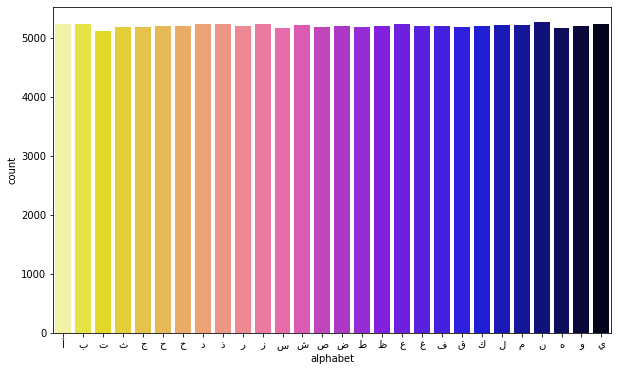

In [2]:
kaggleTrain_x=pd.read_csv("KaggletrainingImagesCleaned.csv",header=None)
AugmentedTrain_x=pd.read_csv("KaggletrainingImagesCleanedAugmented.csv",header=None)
kaggleTrain_y=pd.read_csv("KaggletrainingLabelsCleaned.csv",header=None )
AugmentedTrain_y=pd.read_csv("KaggletrainingLabelsCleanedAugmented.csv",header=None)



kaggleTrain_x=np.array(kaggleTrain_x)
kaggleTrain_x=kaggleTrain_x/255
kaggleTrain_x=pd.DataFrame(kaggleTrain_x)

AugmentedTrain_x=np.array(AugmentedTrain_x)
AugmentedTrain_x=AugmentedTrain_x/255
AugmentedTrain_x=pd.DataFrame(AugmentedTrain_x)

kaggleTrain_y=np.array(kaggleTrain_y)
kaggleTrain_y=np.array(kaggleTrain_y)
KaggleTrain_y=np.array(kaggleTrain_y)

AugmentedTrain_y=np.array(AugmentedTrain_y)
AugmentedTrain_y=np.array(AugmentedTrain_y)
AugmentedTrain_y=np.array(AugmentedTrain_y)



y_train =np.concatenate((kaggleTrain_y,AugmentedTrain_y))
framesx = [kaggleTrain_x, AugmentedTrain_x]
x_train  = pd.concat(framesx)


x_train = np.array(x_train)
y_train = np.array(y_train)

# x_train = 1-x_train

# idx = np.random.permutation(len(x_train))
# x_train,y_train = x_train[idx], y_train[idx]




x_train = x_train.reshape([-1, 32, 32, 1])

y=y_train
y_train=y_train.reshape(-1)



y_train=pd.get_dummies(y_train).values
 
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}
ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_train]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()


# Pre-Processing the testing images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



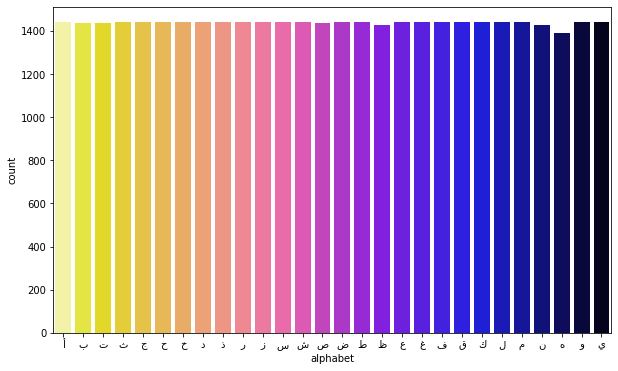

(40233, 32, 32, 1)

In [3]:
kaggleTest_x=pd.read_csv("KaggletestingImagesCleaned.csv",header=None )
AugmentedTest_x=pd.read_csv("KaggletestingImagesCleanedAugmented.csv",header=None)
kaggleTest_y=pd.read_csv("KaggletestingLabelsCleaned.csv",header=None )
AugmentedTest_y=pd.read_csv("KaggletestingLabelsCleanedAugmented.csv",header=None)


kaggleTest_x=np.array(kaggleTest_x)
kaggleTest_x=kaggleTest_x/255
kaggleTest_x=pd.DataFrame(kaggleTest_x)

AugmentedTest_x=np.array(AugmentedTest_x)
AugmentedTest_x=AugmentedTest_x/255
AugmentedTest_x=pd.DataFrame(AugmentedTest_x)


kaggleTest_y=np.array(kaggleTest_y)
kaggleTest_y=np.array(kaggleTest_y)
kaggleTest_y=np.array(kaggleTest_y)

AugmentedTest_y=np.array(AugmentedTest_y)
AugmentedTest_y=np.array(AugmentedTest_y)
AugmentedTest_y=np.array(AugmentedTest_y)


y_test =np.concatenate((kaggleTest_y,AugmentedTest_y))
framesxtest = [kaggleTest_x, AugmentedTest_x]
x_test  = pd.concat(framesxtest)


x_test = np.array(x_test)
y_test = np.array(y_test)

# x_test = 1-x_test
# np.random.seed(10)
# idx = np.random.permutation(len(x_test))
# x_test,y_test = x_test[idx], y_test[idx]

x_test = x_test.reshape([-1, 32, 32, 1])

y=y_test
y_test=y_test.reshape(-1)

y_test=pd.get_dummies(y_test).values


y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}

ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_test]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()
x_test.shape

# Pre-Processing the vaildation images

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



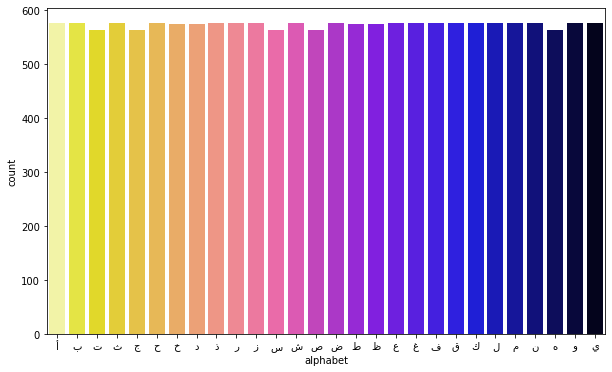

In [4]:
kagglevaildation_x=pd.read_csv("KagglevaildationImagesCleaned.csv",header=None)
Augmentedvaildation_x=pd.read_csv("KagglevaildationImagesCleanedAugmented.csv",header=None)
kagglevaildation_y=pd.read_csv("KagglevaildationLabelsCleaned.csv",header=None )
Augmentedvaildation_y=pd.read_csv("KagglevaildationLabelsCleanedAugmented.csv",header=None)



kagglevaildation_x=np.array(kagglevaildation_x)
kagglevaildation_x=kagglevaildation_x/255
kagglevaildation_x=pd.DataFrame(kagglevaildation_x)

Augmentedvaildation_x=np.array(Augmentedvaildation_x)
Augmentedvaildation_x=Augmentedvaildation_x/255
Augmentedvaildation_x=pd.DataFrame(Augmentedvaildation_x)

kagglevaildation_y=np.array(kagglevaildation_y)


Augmentedvaildation_y=np.array(Augmentedvaildation_y)




y_val =np.concatenate((kagglevaildation_y,Augmentedvaildation_y))
framesx = [kagglevaildation_x, Augmentedvaildation_x]
x_val  = pd.concat(framesx)


x_val = np.array(x_val)
y_val = np.array(y_val)


# idx = np.random.permutation(len(x_val))
# x_val,y_val = x_val[idx], y_val[idx]




x_val = x_val.reshape([-1, 32, 32, 1])
y=y_val
y_val=y_val.reshape(-1)


y_val=pd.get_dummies(y_val).values
y=pd.DataFrame(y)
y.rename(columns={0:"abc"},inplace=True)
cha_dic={1:"أ", 2:"ب",3:"ت",4:"ث",5:"ج",6:"ح",7:"خ",8:"د",9:"ذ",10:"ر",11:"ز",12:"س",13:"ش",14:"ص",15:"ض",16:"ط",17:"ظ",18:"ع"
,19:"غ",20:"ف",21:"ق",22:"ك",23:"ل",24:"م",25:"ن",26:"ه",27:"و",28:"ي"}
ccc=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
temp=y.abc.apply(lambda x:cha_dic[x])
y_class = [np.argmax(element) for element in y_val]
plt.figure(figsize=(10,6))
co=sn.countplot(temp,palette="gnuplot2_r",order=ccc)
plt.xlabel("alphabet")
plt.show()



# Show examples from training images

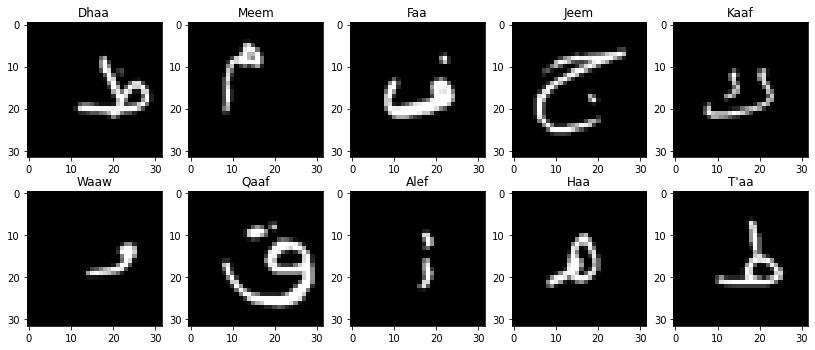

In [44]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_val]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(0, 500)
    plt.imshow(x_val[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

#  Show examples from testing images

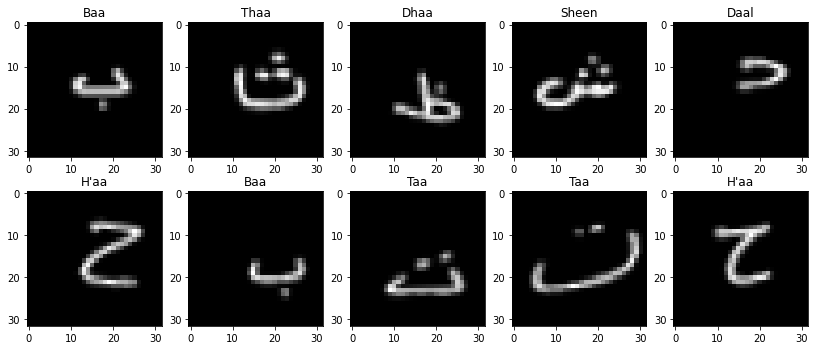

In [40]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']
y_class = [np.argmax(element) for element in y_test]

plt.figure(figsize=(14,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    x = random.randint(15000, 30000)
    plt.imshow(x_test[x].reshape(32,32),"gray")
    plt.title(arabic_characters[y_class[x]])
plt.show()

# proposed CNN model

In [47]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(32, 32,1)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=30,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 144623 samples, validate on 16063 samples
Epoch 1/30
144623/144623 [==============================] - 25s 171us/step - loss: 0.6450 - accuracy: 0.7908 - val_loss: 0.1076 - val_accuracy: 0.9658
Epoch 2/30
144623/144623 [==============================] - 25s 174us/step - loss: 0.1778 - accuracy: 0.9449 - val_loss: 0.0661 - val_accuracy: 0.9801
Epoch 3/30
144623/144623 [==============================] - 26s 179us/step - loss: 0.1380 - accuracy: 0.9580 - val_loss: 0.0564 - val_accuracy: 0.9831
Epoch 4/30
144623/144623 [==============================] - 26s 177us/step - loss: 0.1219 - accuracy: 0.9633 - val_loss: 0.0599 - val_accuracy: 0.9828
Epoch 5/30
144623/144623 [==============================] - 26s 177us/step - loss: 0.1142 - accuracy: 0.9664 - val_loss: 0.0642 - val_accuracy: 0.9839
Epoch 6/30
144623/144623 [==============================] - 26s 177us/step - loss: 0.1105 - accuracy: 0.9675 - val_loss: 0.0586 - val_accuracy: 0.9853
Epoch 7/30
144623/144623 [=================

[0.07537061501156207, 0.980786919593811]

# Saving the model & model's history

In [48]:
accuracy=round(accuracy[1],5)*100

save_model= str(accuracy)+"KaggleAugmented_ourmodel"

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5" )

# Loading the model & model's history

In [7]:
pickle_in= open(save_model,"rb")
history=pickle.load(pickle_in)
model=load_model(save_model+".h5")

# VGG16 with modifications

In [49]:
model = Sequential()
model.add(Conv2D(input_shape=(32,32,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=2, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor], epochs=30,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 144623 samples, validate on 16063 samples
Epoch 1/30
144623/144623 [==============================] - 77s 535us/step - loss: 0.2767 - accuracy: 0.9149 - val_loss: 0.0939 - val_accuracy: 0.9712
Epoch 2/30
144623/144623 [==============================] - 76s 525us/step - loss: 0.0487 - accuracy: 0.9847 - val_loss: 0.0627 - val_accuracy: 0.9841
Epoch 3/30
144623/144623 [==============================] - 76s 528us/step - loss: 0.0323 - accuracy: 0.9899 - val_loss: 0.0736 - val_accuracy: 0.9810
Epoch 4/30
144623/144623 [==============================] - 76s 528us/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.0811 - val_accuracy: 0.9814
Epoch 5/30
144623/144623 [==============================] - 74s 515us/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.1126 - val_accuracy: 0.9803
Epoch 6/30
144623/144623 [==============================] - 75s 522us/step - loss: 0.0190 - accuracy: 0.9943 - val_loss: 0.1053 - val_accuracy: 0.9800
Epoch 7/30
144623/144623 [=================

[0.11500003136668596, 0.977033793926239]

# LeNet5 model

In [50]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (32, 32, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(28, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="best.h5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

history=model.fit(x_train, y_train,validation_data=(x_val,y_val), callbacks=[model_checkpoint_callback], epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Train on 144623 samples, validate on 16063 samples
Epoch 1/50
144623/144623 [==============================] - 50s 347us/step - loss: 0.5379 - accuracy: 0.8311 - val_loss: 0.2357 - val_accuracy: 0.9282

Epoch 00001: val_accuracy improved from -inf to 0.92816, saving model to C:\Users\MOneb\deep learning\Final\KaggleAugmentedModels\best.h5
Epoch 2/50
144623/144623 [==============================] - 49s 340us/step - loss: 0.1484 - accuracy: 0.9529 - val_loss: 0.7954 - val_accuracy: 0.7740

Epoch 00002: val_accuracy did not improve from 0.92816
Epoch 3/50
144623/144623 [==============================] - 49s 342us/step - loss: 0.0984 - accuracy: 0.9685 - val_loss: 0.0780 - val_accuracy: 0.9806

Epoch 00003: val_accuracy improved from 0.92816 to 0.98064, saving model to C:\Users\MOneb\deep learning\Final\KaggleAugmentedModels\best.h5
Epoch 4/50
144623/144623 [==============================] - 50s 348us/step - loss: 0.0777 - accuracy: 0.9756 - val_loss: 0.0471 - val_accuracy: 0.9875

Epoch 0


Epoch 00037: val_accuracy did not improve from 0.99234
Epoch 38/50
144623/144623 [==============================] - 48s 335us/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.0521 - val_accuracy: 0.9913

Epoch 00038: val_accuracy did not improve from 0.99234
Epoch 39/50
144623/144623 [==============================] - 49s 341us/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0489 - val_accuracy: 0.9929

Epoch 00039: val_accuracy improved from 0.99234 to 0.99290, saving model to C:\Users\MOneb\deep learning\Final\KaggleAugmentedModels\best.h5
Epoch 40/50
144623/144623 [==============================] - 49s 340us/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0553 - val_accuracy: 0.9895

Epoch 00040: val_accuracy did not improve from 0.99290
Epoch 41/50
144623/144623 [==============================] - 49s 339us/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0533 - val_accuracy: 0.9915

Epoch 00041: val_accuracy did not improve from 0.99290
Epoch 42/50
144623/144623 

[0.0704762748820816, 0.9871001243591309]

In [56]:
accuracy = str(round(accuracy[1], 5) * 100)

save_model =  accuracy + "KaggleAugmentedBlack_LeNet5"

pickle_out = open(save_model,"wb")
pickle.dump(history, pickle_out) 
pickle_out.close()

model.save(save_model+".h5" )

In [ ]:
pickle_in= open(save_model,"rb")
history=pickle.load(pickle_in)
model=load_model(save_model+".h5")

<AxesSubplot:>

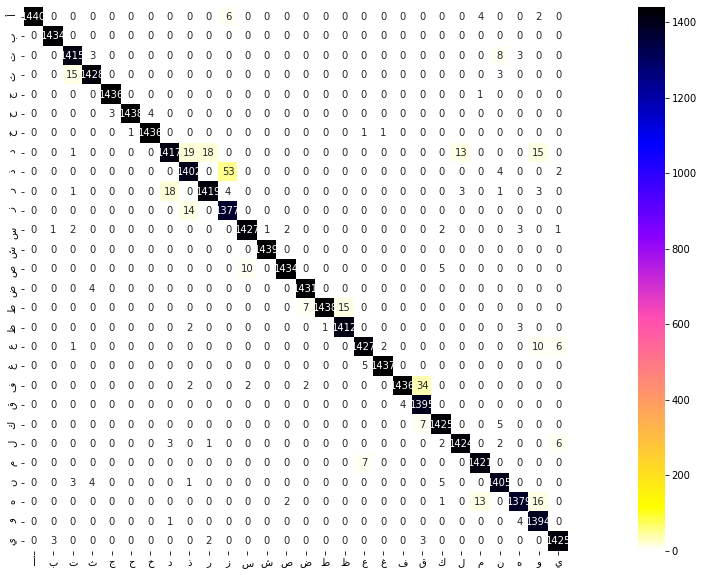

In [9]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
a=confusion_matrix(y_classes, y_classes12)
df_cm = pd.DataFrame(a, index = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"],
                  columns = [i for i in "أبتثجحخدذرزسشصضطظعغفقكلمنهوي"])
plt.figure(figsize = (25,10))
sn.heatmap(df_cm, annot=True,cmap="gnuplot2_r",fmt='g', square=True)

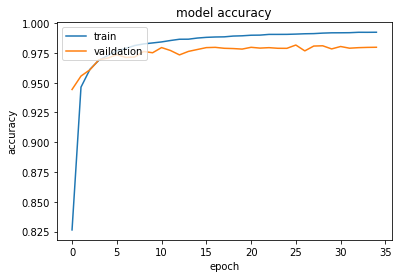

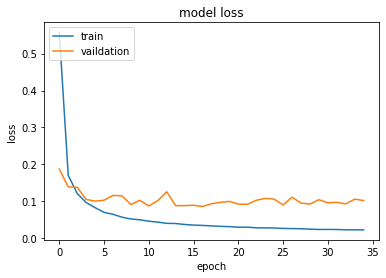

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaildation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaildation'], loc='upper left')
plt.show()

In [10]:
c=classification_report(y_classes, y_classes12, output_dict=True)
df=pd.DataFrame(c).transpose()
df.index=["أ" ,"ب" ,"ت" ,"ث" ,"ج" ,"ح" ,"خ" ,"د" ,"ذ" ,"ر" ,"ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي",'accuracy', 'macro avg', 'weighted avg']
df

,precision,recall,f1-score,support
أ,1.000000,0.991736,0.995851,1452.000000
ب,0.997218,1.000000,0.998607,1434.000000
ت,0.984006,0.990203,0.987095,1429.000000
ث,0.992356,0.987552,0.989948,1446.000000
ج,0.997915,0.999304,0.998609,1437.000000
ح,0.999305,0.995156,0.997226,1445.000000
خ,0.997222,0.997915,0.997569,1439.000000
د,0.984712,0.955496,0.969884,1483.000000
ذ,0.973611,0.959617,0.966563,1461.000000
ر,0.985417,0.979296,0.982347,1449.000000


In [11]:
y_pred = model.predict(x_test)
y_classes = [np.argmax(element) for element in y_pred]
y_classes12 = [np.argmax(element) for element in y_test]
y_acutal=[]
y_miss=[]
ind=[]
img=[]
for i in range(len(y_classes12)):
     if y_classes[i] != y_classes12[i]:
        y_acutal.append(y_classes12[i])
        y_miss.append(y_classes[i])
        img.append(x_test[i])

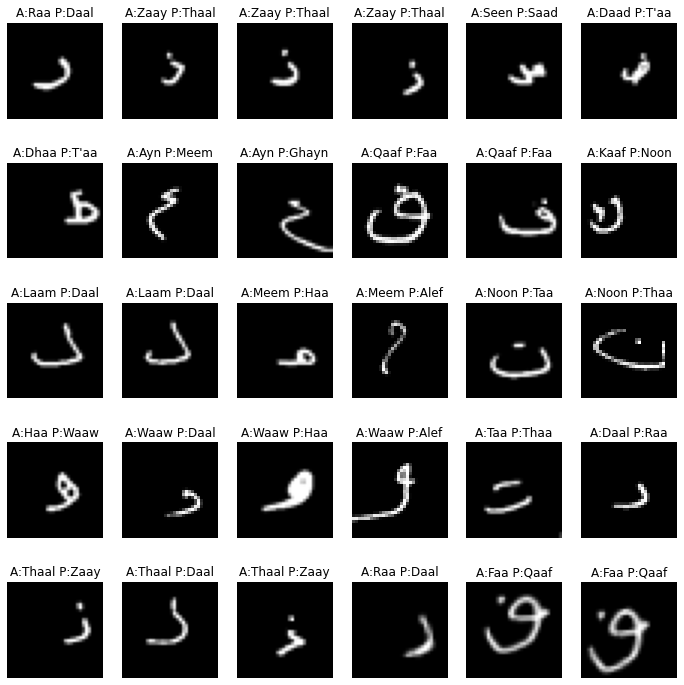

In [12]:
arabic_characters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', "H'aa", 'Khaa', 'Daal', 'Thaal',
                    'Raa', 'Zaay', 'Seen', 'Sheen', 'Saad', 'Daad', "T'aa", 'Dhaa', 'Ayn',
                    'Ghayn', 'Faa', 'Qaaf', 'Kaaf', 'Laam', 'Meem', 'Noon', 'Haa', 'Waaw', 'Yaa']

plt.figure(figsize=(12 ,15))
for i in range(30):
    plt.subplot(6,6,i+1)
    plt.imshow(img[i],"gray")
    plt.axis("OFF")
    plt.title("A:"+arabic_characters[y_acutal[i]]+" P:"+arabic_characters[y_miss[i]])
plt.show()

# Residual-net

In [53]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

# define model input
visible = Input(shape=(32, 32, 1))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
model.save("Res.h5" )
prev_model = load_model("Res.h5")
model=Sequential()
model.add(prev_model)
model.add(Flatten())
model.add(Dense(28, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor]  ,epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 32, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 64)   128         input_1[0][0]                    
____________________________________________________________________________________________

C:\Users\MOneb\anaconda3\envs\ev_2\lib\site-packages\keras\engine\saving.py:341: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



Train on 144623 samples, validate on 16063 samples
Epoch 1/50
144623/144623 [==============================] - 26s 183us/step - loss: 0.5801 - accuracy: 0.8249 - val_loss: 0.3559 - val_accuracy: 0.8914
Epoch 2/50
144623/144623 [==============================] - 27s 185us/step - loss: 0.1771 - accuracy: 0.9425 - val_loss: 0.3253 - val_accuracy: 0.9061
Epoch 3/50
144623/144623 [==============================] - 26s 182us/step - loss: 0.0938 - accuracy: 0.9691 - val_loss: 0.3054 - val_accuracy: 0.9216
Epoch 4/50
144623/144623 [==============================] - 27s 185us/step - loss: 0.0577 - accuracy: 0.9806 - val_loss: 0.3855 - val_accuracy: 0.9150
Epoch 5/50
144623/144623 [==============================] - 27s 186us/step - loss: 0.0390 - accuracy: 0.9868 - val_loss: 0.3831 - val_accuracy: 0.9237
Epoch 6/50
144623/144623 [==============================] - 26s 180us/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 0.4040 - val_accuracy: 0.9272
Epoch 7/50
144623/144623 [=================

[0.9021557328367705, 0.9165112972259521]

# inceptionV3

In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes failters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = Input(shape=(32, 32, 1))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
model.save("inc.h5" )
prev_model = load_model("inc.h5")
model=Sequential()
model.add(prev_model)
model.add(Flatten())
model.add(Dense(28, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)


history=model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=[monitor]  ,epochs=50,verbose=1, batch_size = 32)
accuracy=model.evaluate(x_test,y_test)
accuracy
#94.9